Video Link (dua soal sama): https://drive.google.com/file/d/1g6zunjKlR_FJnqGw4VWsucqZvNUatZUc/view?usp=sharing

In [1]:
import pandas as pd
import numpy as np

In [3]:
df = pd.read_csv("Scraped Articles.csv")

In [4]:
df.head()

,Unnamed: 0,Title,Text,Source,URL,Label
0,0,"Selangkah Gabung City, Vitor Reis Pamitan deng...",Vitor Reis tinggal menunggu waktu sebelum resm...,https://sport.detik.com,https://sport.detik.com/sepakbola/liga-inggris...,Liga Inggris
1,1,Arsenal Vs MU: 10 Pemain Setan Merah Menang Ad...,Juara bertahan Manchester United masih melaju ...,https://sport.detik.com,https://sport.detik.com/sepakbola/liga-inggris...,Liga Inggris
2,2,Amad Bikin Amorim Lancar Ngobrol dengan Ratcliffe,Ruben Amorim bertemu Sir Jim Ratcliffe usai ke...,https://sport.detik.com,https://sport.detik.com/sepakbola/liga-inggris...,Liga Inggris
3,3,"Scholes Kecam MU: Cuma Amad Diallo yang Bagus,...",Paul Scholes mengecam performa Manchester Unit...,https://sport.detik.com,https://sport.detik.com/sepakbola/liga-inggris...,Liga Inggris
4,4,Guardiola Harus Menjilat Ludahnya Sendiri,Pep Guardiola harus menjilat ludahnya sendiri....,https://sport.detik.com,https://sport.detik.com/sepakbola/liga-inggris...,Liga Inggris


In [5]:
df.drop(columns= df.columns[0], inplace=True)
df = df.astype(str)

In [6]:
df["Text"].apply(len).max()


4944

In [ ]:
df.loc[59]

,59
Title,Foto Liga Spanyol Hari Ini - Foto Terbaru Terkini
Text,nan
Source,https://www.liputan6.com
URL,https://www.liputan6.com/hot/read/5712885/biog...
Label,Liga Spanyol


In [7]:
df = df[df["Text"] != "nan"]

In [8]:
len(df)

105

<Axes: ylabel='Label'>

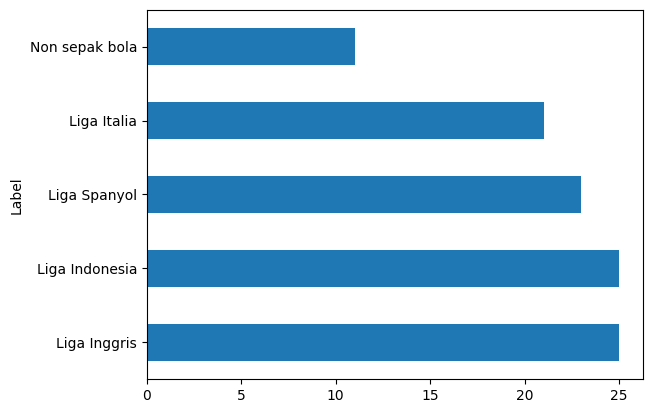

In [9]:
df["Label"].value_counts().plot(kind='barh')

In [ ]:
pip install wordcloud


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 547.9/547.9 kB 7.5 MB/s eta 0:00:00


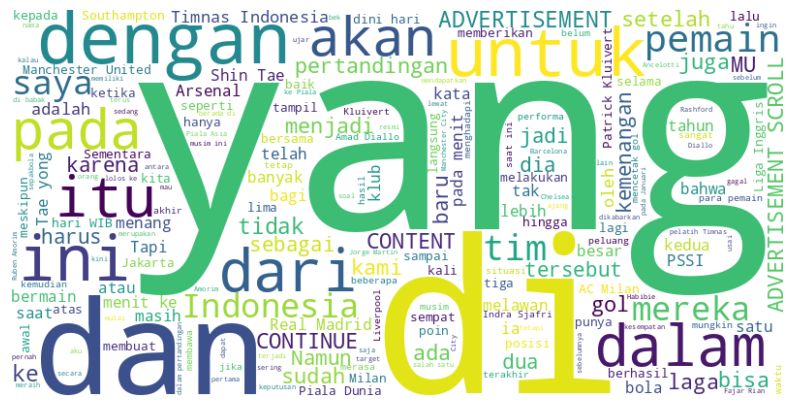

In [ ]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Create the word cloud
text = " ".join(df["Text"].astype(str))
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

# Display the word cloud
plt.figure(figsize=(10, 10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()


## Preprocessing

### Text cleaning

In [10]:
import regex as re
def clean(text):
 return re.sub(r'[^A-Za-z0-9. s]', '', text)

### Pipeline

In [11]:
pipeline = [str.lower, clean]
def prepare(text, pipeline):
  tokens = text
  for transform in pipeline:
    tokens = transform(tokens)

  return tokens

In [12]:
df['Text_Processed'] = df['Text'].apply(prepare,pipeline=pipeline)

# Train Test Split

In [13]:
df_copy = df.copy()

df_copy = df_copy[["Text_Processed", "Label"]]

# Encode labels as integers
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
df_copy["Label"] = label_encoder.fit_transform(df_copy["Label"])

df_train = df_copy.sample(frac=0.75, random_state=98)
df_test = df_copy.drop(df_train.index)
df_val = df_test.sample(frac = 0.5, random_state = 30)
df_test = df_test.drop(df_val.index)

# Model Training

## LLM Task 1 V2

In [14]:
import torch
from torch.utils.data import DataLoader
from transformers import BertTokenizer, BertForSequenceClassification, AdamW, Trainer, TrainingArguments, AutoModelForSequenceClassification

### Load pretrained

In [15]:
# Load the tokenizer
tokenizer = BertTokenizer.from_pretrained('indolem/indobert-base-uncased')

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/42.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/234k [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.01k [00:00<?, ?B/s]

### Tokenizer

In [17]:
from transformers import AutoTokenizer
from datasets import Dataset, DatasetDict

tokenizer = AutoTokenizer.from_pretrained("indolem/indobert-base-uncased")
dataset_train = Dataset.from_pandas(df_train)
dataset_test = Dataset.from_pandas(df_test)
dataset_val = Dataset.from_pandas(df_val)

# RENAME COLUMN TO 'labels'
dataset_train = dataset_train.rename_column("Label", "labels")
dataset_test = dataset_test.rename_column("Label", "labels")
dataset_val = dataset_val.rename_column("Label", "labels")
MAX_LEN = 500
def tokenize_function(examples):
    return tokenizer(examples["Text_Processed"], padding="max_length", truncation=True, max_length = MAX_LEN)


small_train_dataset = dataset_train.map(tokenize_function, batched=True)
small_test_dataset = dataset_test.map(tokenize_function, batched=True)
small_val_dataset = dataset_val.map(tokenize_function, batched=True)

Map:   0%|          | 0/79 [00:00<?, ? examples/s]

Map:   0%|          | 0/13 [00:00<?, ? examples/s]

Map:   0%|          | 0/13 [00:00<?, ? examples/s]

### Create Evaluation Function

In [18]:
import numpy as np
import evaluate

metric = evaluate.load("accuracy")
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return metric.compute(predictions=predictions, references=labels)

### Hyperparameter Tuning

In [ ]:
# pip install optuna

In [21]:
import optuna
from transformers import Trainer, TrainingArguments
from transformers import BertForSequenceClassification, BertTokenizer


def objective(trial):

    learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-3)
    warmup_steps = trial.suggest_categorical('warmup_steps', [0, 3, 5])

    model = AutoModelForSequenceClassification.from_pretrained('indolem/indobert-base-uncased', num_labels=5)


    training_args = TrainingArguments(
        output_dir="./res",
        warmup_steps = warmup_steps,
        learning_rate= learning_rate,
        evaluation_strategy="epoch",
        num_train_epochs = 5,
        logging_dir = './logs'
    )
    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=small_train_dataset,
        eval_dataset=small_val_dataset,
        compute_metrics=compute_metrics,
    )
    trainer.train()
    result = trainer.evaluate()

    return result['eval_accuracy']

study = optuna.create_study(direction="maximize")  # We want to maximize accuracy
study.optimize(objective, n_trials=5)  # Number of trials to run

print(f"Best trial: {study.best_trial}")


[I 2025-01-24 07:00:53,088] A new study created in memory with name: no-name-202b2123-f52a-4500-9876-4e1e90c72f3c
<ipython-input-21-da8533bc3e41>:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-3)


pytorch_model.bin:   0%|          | 0.00/445M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indolem/indobert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.


<IPython.core.display.Javascript object>

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


Epoch,Training Loss,Validation Loss,Accuracy
1,No log,3.212087,0.153846
2,No log,2.578728,0.230769
3,No log,2.142330,0.153846
4,No log,1.721962,0.076923
5,No log,1.768867,0.076923


[I 2025-01-24 07:02:15,315] Trial 0 finished with value: 0.07692307692307693 and parameters: {'learning_rate': 0.000972747902993506, 'warmup_steps': 5}. Best is trial 0 with value: 0.07692307692307693.
<ipython-input-21-da8533bc3e41>:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-3)
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indolem/indobert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers.

Epoch,Training Loss,Validation Loss,Accuracy
1,No log,1.328732,0.538462
2,No log,0.654694,0.769231
3,No log,0.576236,0.846154
4,No log,0.660382,0.846154
5,No log,0.717704,0.846154


[I 2025-01-24 07:03:03,250] Trial 1 finished with value: 0.8461538461538461 and parameters: {'learning_rate': 9.415159868379277e-05, 'warmup_steps': 3}. Best is trial 1 with value: 0.8461538461538461.
<ipython-input-21-da8533bc3e41>:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-3)
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indolem/indobert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. 

Epoch,Training Loss,Validation Loss,Accuracy
1,No log,1.157433,0.615385
2,No log,0.394390,0.846154
3,No log,0.462179,0.846154
4,No log,0.765179,0.846154
5,No log,0.793511,0.846154


[I 2025-01-24 07:03:48,910] Trial 2 finished with value: 0.8461538461538461 and parameters: {'learning_rate': 0.00015987232175668372, 'warmup_steps': 3}. Best is trial 1 with value: 0.8461538461538461.
<ipython-input-21-da8533bc3e41>:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-3)
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indolem/indobert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers.

Epoch,Training Loss,Validation Loss,Accuracy
1,No log,1.132796,0.615385
2,No log,0.412253,0.846154
3,No log,0.578597,0.846154
4,No log,1.061844,0.846154
5,No log,1.114628,0.846154


[I 2025-01-24 07:04:41,109] Trial 3 finished with value: 0.8461538461538461 and parameters: {'learning_rate': 0.0002503455336046591, 'warmup_steps': 3}. Best is trial 1 with value: 0.8461538461538461.
<ipython-input-21-da8533bc3e41>:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-3)
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indolem/indobert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. 

Epoch,Training Loss,Validation Loss,Accuracy
1,No log,1.358846,0.461538
2,No log,2.133139,0.307692
3,No log,2.192282,0.230769
4,No log,1.797568,0.153846
5,No log,1.812405,0.076923


[I 2025-01-24 07:05:35,730] Trial 4 finished with value: 0.07692307692307693 and parameters: {'learning_rate': 0.0003917406178694047, 'warmup_steps': 3}. Best is trial 1 with value: 0.8461538461538461.


Best trial: FrozenTrial(number=1, state=1, values=[0.8461538461538461], datetime_start=datetime.datetime(2025, 1, 24, 7, 2, 15, 318265), datetime_complete=datetime.datetime(2025, 1, 24, 7, 3, 3, 249826), params={'learning_rate': 9.415159868379277e-05, 'warmup_steps': 3}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'learning_rate': FloatDistribution(high=0.001, log=True, low=1e-05, step=None), 'warmup_steps': CategoricalDistribution(choices=(0, 3, 5))}, trial_id=1, value=None)


### Training

In [24]:
from transformers import TrainingArguments, Trainer

# Best Hyperparameters : {'learning_rate': 9.415159868379277e-05, 'warmup_steps': 3}
model = AutoModelForSequenceClassification.from_pretrained('indolem/indobert-base-uncased', num_labels=5)

training_args = TrainingArguments(
        output_dir="./results",
        warmup_steps = 3,
        learning_rate= 9.415159868379277e-05,
        evaluation_strategy="epoch",
        num_train_epochs = 6
    )
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=small_train_dataset,
    eval_dataset=small_val_dataset,
    compute_metrics=compute_metrics,
)
trainer.train()


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indolem/indobert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy
1,No log,1.369455,0.538462
2,No log,0.679815,0.692308
3,No log,0.610204,0.846154
4,No log,0.625023,0.846154
5,No log,0.753162,0.846154
6,No log,0.804645,0.846154


TrainOutput(global_step=60, training_loss=0.40739790598551434, metrics={'train_runtime': 67.7936, 'train_samples_per_second': 6.992, 'train_steps_per_second': 0.885, 'total_flos': 121794921414000.0, 'train_loss': 0.40739790598551434, 'epoch': 6.0})

### Results

In [25]:
from sklearn.metrics import classification_report
LLM_task1_prediction = trainer.predict(small_test_dataset)

print(classification_report(df_test["Label"], LLM_task1_prediction.predictions.argmax(axis=1)))

              precision    recall  f1-score   support

           0       0.50      1.00      0.67         1
           1       1.00      1.00      1.00         3
           2       0.75      0.75      0.75         4
           3       0.67      0.67      0.67         3
           4       1.00      0.50      0.67         2

    accuracy                           0.77        13
   macro avg       0.78      0.78      0.75        13
weighted avg       0.81      0.77      0.77        13



## LLM Task 2

### Tokenizer

In [ ]:
# pip install datasets


In [ ]:
# !pip install --upgrade evaluate


In [26]:
from transformers import AutoTokenizer
from datasets import Dataset, DatasetDict

# LOAD TOKENIZER
tokenizer = AutoTokenizer.from_pretrained("indolem/indobert-base-uncased")

MAX_LEN = 500
def tokenize_function(examples):
    return tokenizer(examples["Text_Processed"], padding="max_length", truncation=True, max_length = MAX_LEN)


### Evaluation Function

In [27]:
import numpy as np
import evaluate

metric = evaluate.load("accuracy")
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return metric.compute(predictions=predictions, references=labels)

### Sepak Bola vs Non Sepak Bola

#### Pretrained model

In [28]:
import torch
from torch.utils.data import DataLoader
from transformers import BertTokenizer, BertForSequenceClassification, AdamW, Trainer, TrainingArguments, AutoModelForSequenceClassification

#### Transform Labels


In [29]:
from datasets import Dataset, DatasetDict

# SPLIT TO 'non sepak bola' AND 'sepak bola'
df_train_binary = df_train.copy()
df_test_binary = df_test.copy()
df_val_binary = df_val.copy()


# Non sepak bola is 4 after Label Encoded
df_train_binary["Label"] = df_train_binary["Label"].apply(lambda x: "Non sepak bola" if x == 4 else "Sepak bola")
df_train_binary = df_train_binary[["Text_Processed", "Label"]]
df_test_binary["Label"] = df_test_binary["Label"].apply(lambda x: "Non sepak bola" if x == 4 else "Sepak bola")
df_test_binary = df_test_binary[["Text_Processed", "Label"]]
df_val_binary["Label"] = df_val_binary["Label"].apply(lambda x: "Non sepak bola" if x == 4 else "Sepak bola")
df_val_binary = df_val_binary[["Text_Processed", "Label"]]

# 1 = sepak bola
# 0 = non sepak bola

# Encode labels as integers
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
df_train_binary["Label"] = label_encoder.fit_transform(df_train_binary["Label"])
df_test_binary["Label"] = label_encoder.transform(df_test_binary["Label"])
df_val_binary["Label"] = label_encoder.transform(df_val_binary["Label"])

# CONVERT TO DATASET OBJECTS
dataset_train_binary = Dataset.from_pandas(df_train_binary)
dataset_test_binary = Dataset.from_pandas(df_test_binary)
dataset_val_binary = Dataset.from_pandas(df_val_binary)

# RENAME COLUMN TO 'labels'
dataset_train_binary = dataset_train_binary.rename_column("Label", "labels")
dataset_test_binary = dataset_test_binary.rename_column("Label", "labels")
dataset_val_binary = dataset_val_binary.rename_column("Label", "labels")

#### Tokenize

In [30]:
tokenized_train_dataset_binary = dataset_train_binary.map(tokenize_function, batched=True)
tokenized_test_dataset_binary = dataset_test_binary.map(tokenize_function, batched=True)
tokenized_val_dataset_binary = dataset_val_binary.map(tokenize_function, batched=True)


Map:   0%|          | 0/79 [00:00<?, ? examples/s]

Map:   0%|          | 0/13 [00:00<?, ? examples/s]

Map:   0%|          | 0/13 [00:00<?, ? examples/s]

#### Hyperparameter Tuning

In [31]:
import optuna
from transformers import Trainer, TrainingArguments
from transformers import BertForSequenceClassification, BertTokenizer


def objective(trial):

    learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-3)
    warmup_steps = trial.suggest_categorical('warmup_steps', [0, 3, 5])

    model = AutoModelForSequenceClassification.from_pretrained('indolem/indobert-base-uncased', num_labels=2)

    training_args = TrainingArguments(
        output_dir="./results",
        warmup_steps = warmup_steps,
        learning_rate=learning_rate,
        evaluation_strategy="epoch",
        num_train_epochs = 5
    )
    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=tokenized_train_dataset_binary,
        eval_dataset=tokenized_val_dataset_binary,
        compute_metrics=compute_metrics,
    )
    trainer.train()

    result = trainer.evaluate()
    return result['eval_accuracy']

study = optuna.create_study(direction="maximize")  # We want to maximize accuracy
study.optimize(objective, n_trials=5)  # Number of trials to run

print(f"Best trial: {study.best_trial}")


[I 2025-01-24 07:14:41,432] A new study created in memory with name: no-name-80c27805-cfc6-4ba2-b29f-df33e73d2b5c
<ipython-input-31-4012c63b4548>:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-3)
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indolem/indobert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy
1,No log,0.639982,0.769231
2,No log,0.988837,0.769231
3,No log,0.676040,0.769231
4,No log,0.964771,0.769231
5,No log,0.961206,0.769231


[I 2025-01-24 07:15:29,753] Trial 0 finished with value: 0.7692307692307693 and parameters: {'learning_rate': 0.0005898049478958887, 'warmup_steps': 3}. Best is trial 0 with value: 0.7692307692307693.
<ipython-input-31-4012c63b4548>:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-3)
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indolem/indobert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. 

Epoch,Training Loss,Validation Loss,Accuracy
1,No log,1.290231,0.769231
2,No log,0.966966,0.769231
3,No log,0.987488,0.769231
4,No log,0.983009,0.769231
5,No log,0.937417,0.769231


[I 2025-01-24 07:16:34,663] Trial 1 finished with value: 0.7692307692307693 and parameters: {'learning_rate': 0.000799423992358785, 'warmup_steps': 3}. Best is trial 0 with value: 0.7692307692307693.
<ipython-input-31-4012c63b4548>:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-3)
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indolem/indobert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. U

Epoch,Training Loss,Validation Loss,Accuracy
1,No log,0.812106,0.769231
2,No log,0.978205,0.769231
3,No log,0.663466,0.769231
4,No log,0.542060,0.923077
5,No log,0.582770,0.923077


[I 2025-01-24 07:17:39,516] Trial 2 finished with value: 0.9230769230769231 and parameters: {'learning_rate': 0.0004008705752504907, 'warmup_steps': 3}. Best is trial 2 with value: 0.9230769230769231.
<ipython-input-31-4012c63b4548>:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-3)
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indolem/indobert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. 

Epoch,Training Loss,Validation Loss,Accuracy
1,No log,0.969917,0.769231
2,No log,1.018893,0.769231
3,No log,0.871176,0.769231
4,No log,0.798870,0.769231
5,No log,0.800019,0.769231


[I 2025-01-24 07:19:08,140] Trial 3 finished with value: 0.7692307692307693 and parameters: {'learning_rate': 1.3982907602859736e-05, 'warmup_steps': 0}. Best is trial 2 with value: 0.9230769230769231.
<ipython-input-31-4012c63b4548>:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-3)
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indolem/indobert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers.

Epoch,Training Loss,Validation Loss,Accuracy
1,No log,1.165537,0.769231
2,No log,0.893560,0.769231
3,No log,0.860938,0.769231
4,No log,0.875893,0.769231
5,No log,0.787871,0.769231


[I 2025-01-24 07:20:03,424] Trial 4 finished with value: 0.7692307692307693 and parameters: {'learning_rate': 2.9076323834869918e-05, 'warmup_steps': 3}. Best is trial 2 with value: 0.9230769230769231.


Best trial: FrozenTrial(number=2, state=1, values=[0.9230769230769231], datetime_start=datetime.datetime(2025, 1, 24, 7, 16, 34, 666472), datetime_complete=datetime.datetime(2025, 1, 24, 7, 17, 39, 515936), params={'learning_rate': 0.0004008705752504907, 'warmup_steps': 3}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'learning_rate': FloatDistribution(high=0.001, log=True, low=1e-05, step=None), 'warmup_steps': CategoricalDistribution(choices=(0, 3, 5))}, trial_id=2, value=None)


#### Training

Turns out using the default learning rate with 0 warm up steps gives the best results

learning_rate = 0.00005


In [32]:
from transformers import TrainingArguments, Trainer

model = AutoModelForSequenceClassification.from_pretrained('indolem/indobert-base-uncased', num_labels=2)

training_args = TrainingArguments(output_dir="test_trainer", eval_strategy="epoch", num_train_epochs = 6)

binary_trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train_dataset_binary,
    eval_dataset=tokenized_val_dataset_binary,
    compute_metrics=compute_metrics,
)

binary_trainer.train()

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indolem/indobert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy
1,No log,1.060891,0.769231
2,No log,0.480804,0.769231
3,No log,0.470312,0.923077
4,No log,0.529317,0.923077
5,No log,0.550359,0.923077
6,No log,0.555872,0.923077


TrainOutput(global_step=60, training_loss=0.094495956103007, metrics={'train_runtime': 62.902, 'train_samples_per_second': 7.536, 'train_steps_per_second': 0.954, 'total_flos': 121791640860000.0, 'train_loss': 0.094495956103007, 'epoch': 6.0})

### Sepak Bola Subcategory

#### Transform Labels


In [33]:
# SPLIT WITHIN SEPAKBOLA CATEGORIES
df_train_multiple = df_train.copy()
df_test_multiple = df_test.copy()
df_val_multiple = df_val.copy()

df_train_multiple = df_train_multiple[df_train_multiple["Label"] != 4][["Text_Processed", "Label"]]
df_test_multiple = df_test_multiple[df_test_multiple["Label"] != 4][["Text_Processed", "Label"]]
df_val_multiple = df_val_multiple[df_val_multiple["Label"] != 4][["Text_Processed", "Label"]]

# CONVERT TO DATASET OBJECTS
dataset_train_multiple = Dataset.from_pandas(df_train_multiple)
dataset_test_multiple = Dataset.from_pandas(df_test_multiple)
dataset_val_multiple = Dataset.from_pandas(df_val_multiple)

# RENAME COLUMN TO 'labels'
dataset_train_multiple = dataset_train_multiple.rename_column("Label", "labels")
dataset_test_multiple = dataset_test_multiple.rename_column("Label", "labels")
dataset_val_multiple = dataset_val_multiple.rename_column("Label", "labels")


#### Tokenize

In [34]:
tokenized_train_dataset_multiple = dataset_train_multiple.map(tokenize_function, batched=True)
tokenized_test_dataset_multiple = dataset_test_multiple.map(tokenize_function, batched=True)
tokenized_val_dataset_multiple = dataset_val_multiple.map(tokenize_function, batched=True)


Map:   0%|          | 0/73 [00:00<?, ? examples/s]

Map:   0%|          | 0/11 [00:00<?, ? examples/s]

Map:   0%|          | 0/10 [00:00<?, ? examples/s]

#### Hyperparameter Tuning

In [35]:
import optuna
from transformers import Trainer, TrainingArguments
from transformers import BertForSequenceClassification, BertTokenizer


def objective(trial):

    learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-3)
    warmup_steps = trial.suggest_categorical('warmup_steps', [0, 3, 5])

    model = AutoModelForSequenceClassification.from_pretrained('indolem/indobert-base-uncased', num_labels=4)

    training_args = TrainingArguments(
        output_dir="./results",
        warmup_steps = warmup_steps,
        learning_rate=learning_rate,
        evaluation_strategy="epoch",
        num_train_epochs = 5
    )
    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=tokenized_train_dataset_multiple,
        eval_dataset=tokenized_val_dataset_multiple,
        compute_metrics=compute_metrics,
    )
    trainer.train()

    result = trainer.evaluate()
    return result['eval_accuracy']

study = optuna.create_study(direction="maximize")  # We want to maximize accuracy
study.optimize(objective, n_trials=5)  # Number of trials to run

print(f"Best trial: {study.best_trial}")


[I 2025-01-24 07:21:38,148] A new study created in memory with name: no-name-d1c218b0-d9e1-4d19-8aef-7b41aeef735d
<ipython-input-35-ef003e458814>:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-3)
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indolem/indobert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy
1,No log,1.370514,0.200000
2,No log,1.048067,0.600000
3,No log,0.841819,0.600000
4,No log,0.798002,0.600000
5,No log,0.771316,0.600000


[I 2025-01-24 07:22:31,872] Trial 0 finished with value: 0.6 and parameters: {'learning_rate': 2.7030599864663558e-05, 'warmup_steps': 5}. Best is trial 0 with value: 0.6.
<ipython-input-35-ef003e458814>:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-3)
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indolem/indobert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
 

Epoch,Training Loss,Validation Loss,Accuracy
1,No log,0.513863,0.800000
2,No log,0.808655,0.700000
3,No log,0.616742,0.700000
4,No log,0.481686,0.800000
5,No log,0.525918,0.900000


[I 2025-01-24 07:23:35,655] Trial 1 finished with value: 0.9 and parameters: {'learning_rate': 0.0005243212796975114, 'warmup_steps': 5}. Best is trial 1 with value: 0.9.
<ipython-input-35-ef003e458814>:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-3)
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indolem/indobert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  

Epoch,Training Loss,Validation Loss,Accuracy
1,No log,0.708853,0.700000
2,No log,0.383113,0.800000
3,No log,0.325072,0.900000
4,No log,0.462915,0.900000
5,No log,0.532520,0.900000


[I 2025-01-24 07:24:36,181] Trial 2 finished with value: 0.9 and parameters: {'learning_rate': 0.00011876878238608558, 'warmup_steps': 0}. Best is trial 1 with value: 0.9.
<ipython-input-35-ef003e458814>:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-3)
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indolem/indobert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
 

Epoch,Training Loss,Validation Loss,Accuracy
1,No log,0.770046,0.800000
2,No log,0.314327,0.900000
3,No log,0.326706,0.900000
4,No log,0.380773,0.900000
5,No log,0.564998,0.900000


[I 2025-01-24 07:25:31,846] Trial 3 finished with value: 0.9 and parameters: {'learning_rate': 0.00011883868784746048, 'warmup_steps': 3}. Best is trial 1 with value: 0.9.
<ipython-input-35-ef003e458814>:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-3)
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indolem/indobert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
 

Epoch,Training Loss,Validation Loss,Accuracy
1,No log,2.109777,0.100000
2,No log,1.435205,0.200000
3,No log,1.454229,0.100000
4,No log,1.411104,0.300000
5,No log,1.065144,0.400000


[I 2025-01-24 07:26:34,491] Trial 4 finished with value: 0.4 and parameters: {'learning_rate': 0.00036501670937317903, 'warmup_steps': 3}. Best is trial 1 with value: 0.9.


Best trial: FrozenTrial(number=1, state=1, values=[0.9], datetime_start=datetime.datetime(2025, 1, 24, 7, 22, 31, 874294), datetime_complete=datetime.datetime(2025, 1, 24, 7, 23, 35, 655283), params={'learning_rate': 0.0005243212796975114, 'warmup_steps': 5}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'learning_rate': FloatDistribution(high=0.001, log=True, low=1e-05, step=None), 'warmup_steps': CategoricalDistribution(choices=(0, 3, 5))}, trial_id=1, value=None)


#### Training

In [37]:
# A lot of ties but this one converged faster
# best hyperparameters : {'learning_rate': 0.00011883868784746048, 'warmup_steps': 3}

from transformers import TrainingArguments, Trainer


model_cat = AutoModelForSequenceClassification.from_pretrained('indolem/indobert-base-uncased', num_labels=4)


training_args = TrainingArguments(
    output_dir="test_trainer",
    learning_rate = 0.0005243212796975114,
    warmup_steps = 5,
    eval_strategy="epoch",
    num_train_epochs = 6
)

sepak_bola_trainer = Trainer(
    model=model_cat,
    args=training_args,
    train_dataset=tokenized_train_dataset_multiple,
    eval_dataset=tokenized_val_dataset_multiple,
    compute_metrics=compute_metrics,
)

sepak_bola_trainer.train()


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indolem/indobert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy
1,No log,0.454633,0.900000
2,No log,0.893199,0.800000
3,No log,3.038537,0.600000
4,No log,1.298408,0.700000
5,No log,0.067332,1.000000
6,No log,0.007052,1.000000


TrainOutput(global_step=60, training_loss=0.8304917653401692, metrics={'train_runtime': 47.4819, 'train_samples_per_second': 9.225, 'train_steps_per_second': 1.264, 'total_flos': 112543663752000.0, 'train_loss': 0.8304917653401692, 'epoch': 6.0})

### Results

In [54]:
from sklearn.metrics import classification_report

# USE THE FIRST MODEL TO GET BINARY PREDICTIONS
binary_prediction = binary_trainer.predict(tokenized_test_dataset_binary).predictions.argmax(axis=1)

# CREATE A DATASET OBJECT USING DF_TEST AND THE BINARY PREDICTIONS
df_binary_prediction = pd.concat([df_test["Text_Processed"].reset_index(), pd.DataFrame(binary_prediction, columns = ["labels"])], axis = 1)

# CREATE FINAL PREDICTION DATASET
dataset_FINAL = df_binary_prediction.copy()

# TAKE SEPAKBOLA CATEGORIES PREDICTION
# Sepakbola = 1
# Non Sepakbola = 0

dataset_binary_prediction = Dataset.from_pandas(df_binary_prediction)
dataset_binary_prediction = dataset_binary_prediction.filter(lambda example: example["labels"] == 1)

# TOKENIZE
tokenized_binary_prediction = dataset_binary_prediction.map(tokenize_function, batched=True)

# PREDICT USING THE SUBCATOGERIZER
subcategories_prediction = sepak_bola_trainer.predict(tokenized_binary_prediction).predictions.argmax(axis = 1)

# REPLACE THE "Non Sepakbola" CLASS WITH ITS ORIGINAL LABEL (4)
dataset_FINAL["labels"] = dataset_FINAL["labels"].apply(lambda x: 4 if x == 0 else x)

# Fill in the final dataset
for i in range(len(subcategories_prediction)):
    if dataset_FINAL.iloc[i]["labels"] == 1:
      dataset_FINAL.loc[i,"labels"] = subcategories_prediction[i]


# GET CLASSIFICATION REPORT

print(classification_report(df_test['Label'], dataset_FINAL['labels']))


Filter:   0%|          | 0/13 [00:00<?, ? examples/s]

Map:   0%|          | 0/12 [00:00<?, ? examples/s]

              precision    recall  f1-score   support

           0       0.50      1.00      0.67         1
           1       0.75      1.00      0.86         3
           2       0.75      0.75      0.75         4
           3       1.00      0.67      0.80         3
           4       1.00      0.50      0.67         2

    accuracy                           0.77        13
   macro avg       0.80      0.78      0.75        13
weighted avg       0.83      0.77      0.77        13



In [ ]:
from sklearn.metrics import classification_report
LLM_task1_prediction = trainer.predict(small_test_dataset)

print(classification_report(df_test["Label"], LLM_task1_prediction.predictions.argmax(axis=1)))

              precision    recall  f1-score   support

           0       0.50      1.00      0.67         1
           1       1.00      1.00      1.00         3
           2       0.75      0.75      0.75         4
           3       0.67      0.67      0.67         3
           4       1.00      0.50      0.67         2

    accuracy                           0.77        13
   macro avg       0.78      0.78      0.75        13
weighted avg       0.81      0.77      0.77        13



### Analysis

Both approaches have very similar performances with only small variances in the Sepak Bola classes.

The effects of using the method of doing a binary classification before a multilabel  isn't apparent. This might be because of a lack of representation of the Non Sepak Bola class in the testing dataset (only two entries). So even if the second model is slightly better at recognizing Sepak Bola and Non Sepak Bola categories, it might not reflect this in the results.

In [60]:
list(df_test["Label"])

[1, 1, 1, 0, 3, 3, 3, 2, 2, 2, 2, 4, 4]

In [59]:
list(LLM_task1_prediction.predictions.argmax(axis=1))

[1, 1, 1, 0, 2, 3, 3, 3, 2, 2, 2, 4, 0]

In [58]:
list( dataset_FINAL['labels'])

[1, 1, 1, 0, 2, 3, 3, 0, 2, 2, 2, 4, 1]